In [1]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap

### Load data

We begin by loading the arbor density, latent space, and cell annotation data, and restrict ourselves to only those cells where morphological data is available. This data is taken from EM, ME, fMOST, and Patch-Seq experiments.

In [2]:
# Load arbor density data (generated by data_proc_M.py in Fahimeh's cplAE_MET repository)
arbor_dict = sio.loadmat("../data/raw/M_arbor_data_50k_4Apr23.mat")
# The arbor density is not filtered in advance, to preserve index correspondence with the annotation dataframe
arbors = arbor_dict["hist_ax_de_api_bas"]
# Load 3D latent space data
latent_dict = np.load("../data/remote/morpho/reference_3d/outputs.npz")
latent = latent_dict["latent_space"]
latent_ids = pd.DataFrame(data = {"specimen_id": latent_dict["specimen_ids"], "latent_index": range(len(latent_dict["specimen_ids"]))})
# Load corresponding cell annotation file
arbor_ids = pd.DataFrame(data = {"specimen_id": arbor_dict["specimen_id"], "arbor_index": range(len(arbor_dict["specimen_id"]))})
anno_csv = pd.read_csv("../data/raw/exc_inh_ME_fMOST_EM_specimen_ids_shuffled_4Apr23.txt")
# Join arbor and latent data with annotation data on the specimen_id to guarantee that the arbor data indices are properly matched
arbor_ids["specimen_id"] = arbor_ids["specimen_id"].str.strip()
latent_ids["specimen_id"] = latent_ids["specimen_id"].str.strip()
anno_csv["specimen_id"] = anno_csv["specimen_id"].str.strip()
anno = pd.merge(anno_csv, arbor_ids, on = "specimen_id", how = "left").drop("Unnamed: 0", axis = 1).query("M_cell")
anno = pd.merge(anno, latent_ids, on = "specimen_id", how = "left")
anno

,specimen_id,platform,class,group,class_id,T_cell,E_cell,M_cell,subgroup,proofread,arbor_index,latent_index
0,864691135274125285_199010,EM,exc,1,0.0,False,False,True,1,NaN,0,28297
1,864691135212658304_427884,EM,exc,1,0.0,False,False,True,1,NaN,2,16521
2,864691135354962383_392595,EM,exc,1,0.0,False,False,True,1,NaN,3,13116
3,864691136656750077_610633,EM,exc,1,0.0,False,False,True,1,NaN,5,44791
4,864691136898656366_396172,EM,exc,1,0.0,False,False,True,1,NaN,6,43633
...,...,...,...,...,...,...,...,...,...,...,...,...
45796,864691135750158472_388862,EM,exc,1,0.0,False,False,True,1,NaN,52252,34713
45797,864691135373371848_297143,EM,exc,1,0.0,False,False,True,1,NaN,52254,5418
45798,864691135714363796_557060,EM,exc,1,0.0,False,False,True,1,NaN,52255,33125
45799,864691135587516402_491694,EM,exc,1,0.0,False,False,True,1,NaN,52256,39502


Looking at the distribution of excitatory and inhibitory cells across the difference experiment types, we can see that there is a massive asymmetry for the EM data. This will need to be taken into consideration in our subsequent analysis.

In [3]:
pd.pivot_table(anno, index = "platform", columns = "class", values = "arbor_index", aggfunc = "count")

class,exc,inh
platform,,
EM,43314.0,141.0
ME,244.0,203.0
fMOST,280.0,NaN
patchseq,831.0,788.0


### Raw data analysis

To gauge the degree of separation/clustering that already exists in the raw morphological data, we can train a simple linear discriminant classifier and assess its accuracy at distinguishing EM and Patch-Seq data. By enforcing equal priors across the two experiment types, we tie the accuracy of the classifier directly to how the data clusters.

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [147]:
anno_exc_patchseq = em_patchseq_anno.query("platform == 'patchseq' and `class` == 'exc'")
anno_exc_em = em_patchseq_anno.query("platform == 'EM' and `class` == 'exc'").sample(n = len(anno_exc_patchseq), replace = False)
anno_inh_em = em_patchseq_anno.query("platform == 'EM' and `class` == 'inh'")
anno_inh_patchseq = em_patchseq_anno.query("platform == 'patchseq' and `class` == 'inh'").sample(n = len(anno_inh_em), replace = False)
anno_samp = pd.concat([anno_exc_em, anno_inh_em, anno_exc_patchseq, anno_inh_patchseq])
proj = umap_model.transform(arbors_comb[anno_samp["arbor_index"]])

In [156]:
X = arbors.reshape((arbors.shape[0], -1))[em_patchseq_anno["arbor_index"]]
y = em_patchseq_anno["platform"]
linear = LDA(priors = [0.5, 0.5]).fit(X, y)
linear.score(arbors.reshape((arbors.shape[0], -1))[anno_samp["arbor_index"]], anno_samp["platform"])

0.6450617283950617

The low accuracy here suggests that the EM and Patch-Seq data are not trivially separable. However, the excitatory and inhibitory arbor densities were encoded into distinct slices of the data array, and can therefore be learned independently by a classifier. Let's visualize any differences between cell types by projecting the arbor densities onto the 1D subspace generated by the LDA classifier, and then plotting the excitatory and inhibitory cells separately.

In [157]:
projected_arbors = linear.transform(arbors.reshape((arbors.shape[0], -1))[anno_samp["arbor_index"]])

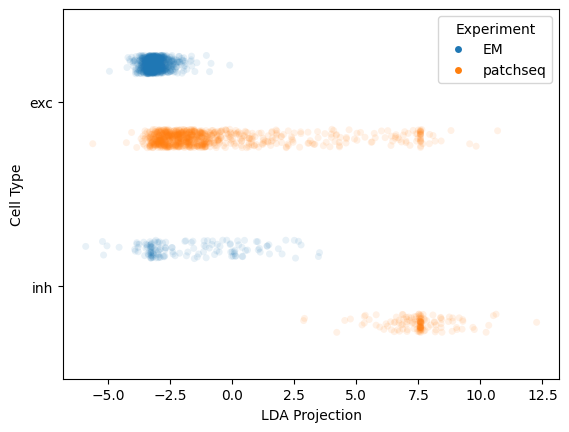

In [158]:
%matplotlib inline
plot = sns.stripplot(data = {"LDA Projection": projected_arbors.squeeze(), "Experiment": anno_samp["platform"], "Cell Type": anno_samp["class"]}, 
              x = "LDA Projection", y = "Cell Type", hue = "Experiment", alpha = 0.1, dodge = True)
for point in plot.legend_.legend_handles:
    point._alpha = 1

We can see that the excitatory cells are more tightly clustered in the EM dataset versus Patch-Seq, but a large overlap still exists between the two experiments. Among inhibitory cells, by contrast, the two experiments form distinct clusters and are easy to separate.

One weakness of these LDA projections is that we cannot easily compare the excitatory and inhibitory cells within a single experiment type. To remedy this, we will merge the excitatory and inhibitory data slices and then create a 2D UMAP projection of the combined data.

In [133]:
arbors_comb = (arbors[..., :2] + arbors[..., 2:]).reshape((arbors.shape[0], -1))
X_comb = arbors_comb[em_patchseq_anno["arbor_index"]]
umap_model = umap.UMAP().fit(X_comb)

In [134]:
proj = umap_model.transform(arbors_comb[anno_samp["arbor_index"]])

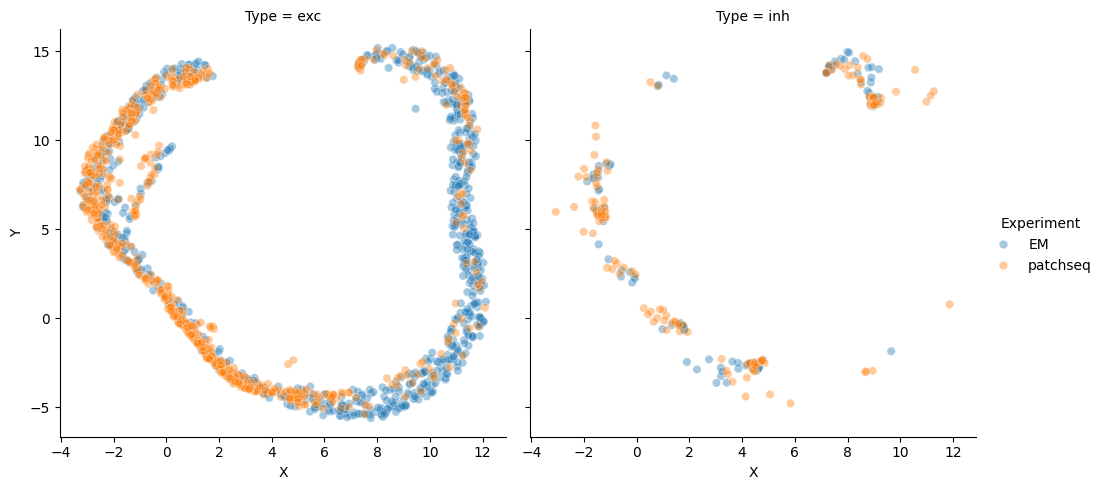

In [136]:
%matplotlib inline
plot = sns.relplot(data = {"X": proj[:, 0], "Y": proj[:, 1], "Experiment": anno_samp["platform"], "Type": anno_samp["class"]}, 
                x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.4)

Interestingly, the LDA and UMAP projections show different patterns. In the LDA excitatory clusters, we see EM cells are more tightly packed than the Patch-Seq cells, while the opposite is true in the UMAP clusters. For the inhibitory cells, UMAP does not yield any real separation, while LDA is capable of significant separation. Both of these observations are likely attributable to the supervised nature LDA, which finds a projection direction in the 960-dimensional arbor space that explicitly seeks label separation (and is able to do so seperately for excitatory and inhibitory cells), while UMAP tries to preserve the overall topology of the combined data even when much of it may not be useful for classification.

## Latent space analysis

Our ultimate goal is to understand the clustering behavior of the latent space in the morphology autoencoder. Given that we expect the encoder-decoder mapping to be relatively smooth, the topology of the raw data ought to be at least roughly reflected in the topology of a latent space that is optimized to reduce and then reconstruct the original data. To evaluate this, we can plot the 3D latent representations of the EM and Patch-Seq experiments from a trained autoencoder.

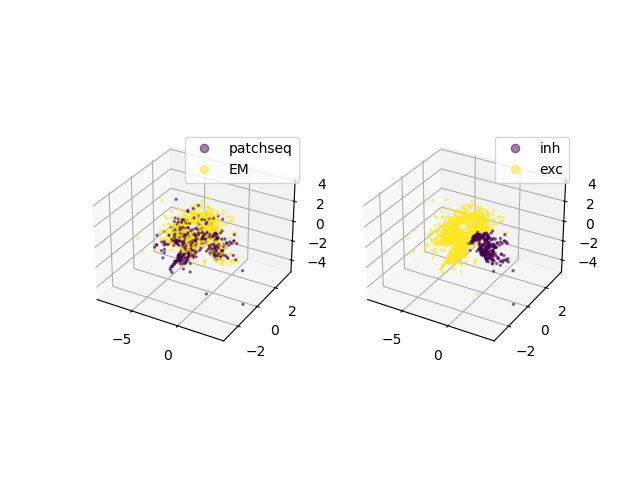

In [115]:
%matplotlib widget
latent_samp = latent[anno_samp.sort_values(by = ["latent_index"], axis = 0)["latent_index"]]
fig = plt.figure()
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = anno_samp.sort_values(by = ["latent_index"], axis = 0)["platform"].factorize()
(factors_type, labels_type) = anno_samp.sort_values(by = ["latent_index"], axis = 0)["class"].factorize()
sc_exp = ax_exp.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())

The plots shown above are consistent with our expectations. For the excitatory cells, we see the same 1D horseshoe topology as in UMAP projections, except this time it slithers through 3D space. The distribution of EM and Patch-Seq data along the projection is also similar, with EM data spread across the entire surface while Patch-Seq is concentrated toward a single side. Looking at the inhibitory cells, we can see that they are fully separated from the excitatory cells, and do not possess any notable difference in distribution between EM and Patch-Seq.